# Метод последовательных приближений для решения задач оптимального управления

*И. А. Крылов, Ф. Л. Черноусько, О методе последовательных приближений для решения задач оптимального управления, Ж. вычисл. матем. и матем. физ., 1962, том 2, номер 6, 1132–1139*

## 1. ODE Solvers

Рассмотрим ОДУ $\dot y(t) = f(t, y(t))$ с начальными условиями $y(0) = y_0$

В качестве примера построим аттрактор Лоренца ([Lorenz attractor](https://en.wikipedia.org/wiki/Lorenz_system)).

In [1]:
from functools import partial
from jax.experimental.ode import odeint
import jax.numpy as jnp
import jax.lax as lax


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
def f(state, t, rho, sigma, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return jnp.array([dxdt, dydt, dzdt])

2024-06-21 13:39:15.186466: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [18]:
def plot_3d_path(ax, ys, color):
    x0, x1, x2 = ys.T
    ax.plot(x0, x1, x2, lw=0.5, color=color)

### 1.1. ODE Solver из библиотеки

In [16]:
ys_odeint = odeint(
    partial(f, rho=28., sigma=10., beta=8./3),
    y0 = jnp.array([5., 5., 5.]),
    t = jnp.linspace(0, 10., 10000)
)

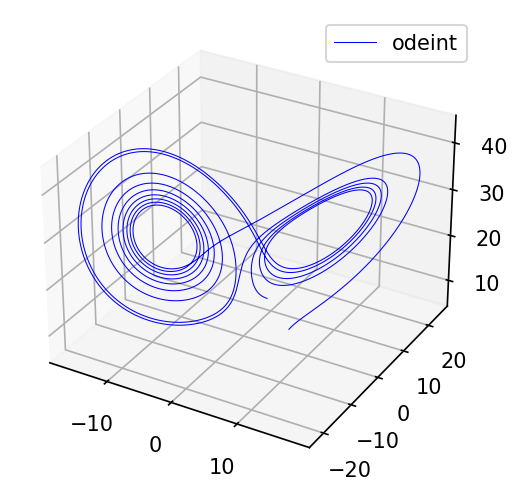

In [17]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d') 
plot_3d_path(ax, ys_odeint, 'b')
ax.legend(['odeint'])
plt.show() 

### 1.2. Euler method

In [19]:
def Euler_method(f, y0, t, *args):
    def step(state, t):
        y_prev, t_prev = state
        dt = t - t_prev
        y = y_prev + dt * f(y_prev, t_prev, *args)
        return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[1:])
    return ys

ys_euler = Euler_method(f, jnp.array([5., 5., 5.]), jnp.linspace(0, 10., 10000), 28., 10., 8./3)
ys_euler

Array([[ 5.       ,  5.110011 ,  5.0116677],
       [ 5.0011   ,  5.219854 ,  5.0238547],
       [ 5.003288 ,  5.329551 ,  5.036564 ],
       ...,
       [ 8.99657  , 14.80037  , 17.578938 ],
       [ 9.054631 , 14.879355 , 17.665247 ],
       [ 9.112846 , 14.958011 , 17.75282  ]], dtype=float32)

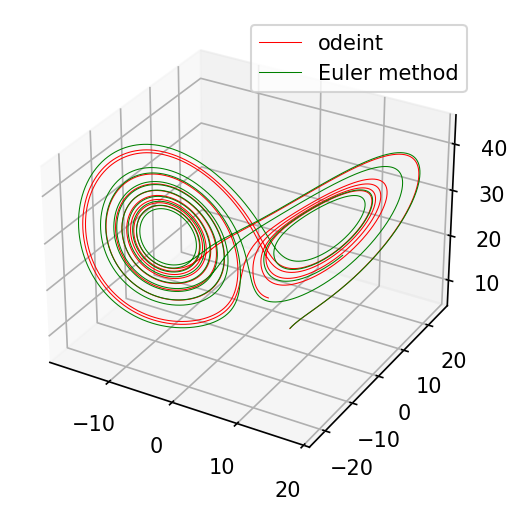

In [20]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d') 

plot_3d_path(ax, ys_odeint, 'r')
plot_3d_path(ax, ys_euler, 'g')
ax.legend(['odeint', 'Euler method'])
plt.show()

## 1.3. Runge–Kutta methods

In [22]:
def RK4_method(f, y0, t, *args):
    def step(state, t):
        y_prev, t_prev = state
        h = t - t_prev
        k1 = h * f(y_prev, t_prev, *args)
        k2 = h * f(y_prev + k1/2., t_prev + h/2., *args)
        k3 = h * f(y_prev + k2/2., t_prev + h/2., *args)
        k4 = h * f(y_prev + k3, t + h, *args)
        y = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[1:])
    return ys

ys_rk4 = RK4_method(f, jnp.array([5., 5., 5.]), jnp.linspace(0, 10., 10000), 28., 10., 8./3)

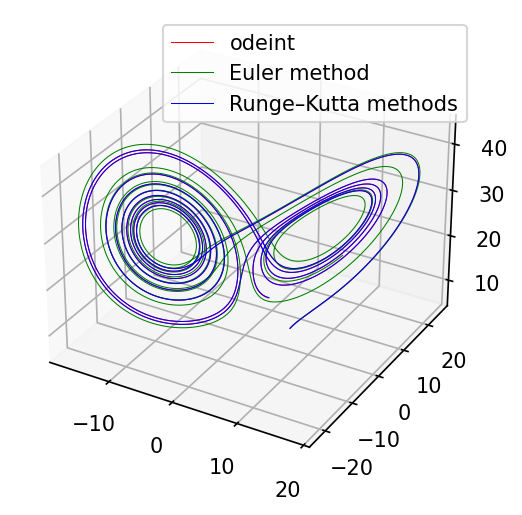

In [23]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')  # Создание трехмерных осей
plot_3d_path(ax, ys_odeint, 'r')
plot_3d_path(ax, ys_euler, 'g')
plot_3d_path(ax, ys_rk4, 'b')
ax.legend(['odeint', 'Euler method', 'Runge–Kutta methods'])
plt.show()  # Отображение графика

## 2. Метод последовательных приближений

Задача состоит в построении допустимого управления $u(t)$, при котором функционал достигает 
наименьшего значения по сравнению с его значениями при других доаустимых управлениях.
Это управление будет называть оптимальным и обозначать через $u^*$

Рассмотрим в качетсве примера следующую систему дифференциальных уравнений (c фиксированным временем $T$):

\begin{cases}
    \dot x_1 = x_2 \\
    \dot x_2 = - x_1 + u
\end{cases}

с начальными условиями $x_1(0) = x_2(0) = 0$

Ограничение на управление: $|u(t)| \leq 1$

Требуется минимизировать функционал $ x_1(T) \rightarrow \min $ , то есть $\varphi_0 = (1, 0, 0)$    

Чтобы привести задачу к общему виду введем новую переменную
$x_3(t) = T$, тогда $\dot x_3(t) = 1$

Тогда новая система:
\begin{cases}
    \dot x_1 = x_2 \\
    \dot x_2 = - x_1 + u \\
    \dot x_3 = 1
\end{cases}

С начальными условиями:
\begin{cases}
    x_1(0) = 0 \\
    x_2(0) = 0 \\
    x_3(0) = 0
\end{cases}    

А функциональное многообразие (пространство возможных траекторий системы управления):
$$M = {x_3(t_k) = T}$$

Выпишим функцию Понтрягина: 

$$H = \psi^T \cdot f(x, t, u)$$

где $\psi$ - сопряженные переменные (adjoint в Neural ODE), 
$u$ - управление ($\theta$ - параметр обучения в Neural ODE) 

$$H = x_2 \psi_1 + (-x_1 + u) \psi_2 = x_2 \psi_1 - x_1\psi_2 + u\psi_2$$

Из П.М.П. знаем, что на оптимальном управлении $u^*$ функция $H$ должна достигать своего максимума.

Для сопряженных переменных выпишим свою систему ОДУ: 
$$\dot \psi = - \frac{dH}{dx}$$

Если соблюдать формулировку статьи NeuralODE, то $\dot \psi = - \psi^T \frac{df}{dx}$, но это одно и то же.


\begin{cases}
    \dot \psi_1 = \psi_2 \\
    \dot \psi_2 = - \psi_1 \\
    \dot \psi_3 = 0 \\
\end{cases}

И должно быть выполнено условие транстверсальности. 
Оно описывает поведение сопряжённых переменных на границе допустимой области. 
Из него мы достанем конечные условия для сопряженной системы:

$$\psi(T) + \lambda_0 \frac{d\varphi_0}{dx} \perp M$$

Перпендикулярность функциональному многообразтю $M$ говорит о том, что скалярное произведение между левой и правой частью должно быть равно нулю. 

$$ 
\begin{cases}
\psi_1(T) +  \lambda_0 \cdot 1 \\
\psi_2(T) + \lambda_0 \cdot 0   \\       
\psi_3(T) + \lambda_0 \cdot 0 \\
\end{cases} 
\perp  M   = (a, b, 0)^T $$

$$(\psi_1(T)+ \lambda_0) \cdot a + \psi_2(T) \cdot b = 0 \quad \forall a, b$$ 

Получаем конечные условия для сопряженной системы диффренциальных уравнений:
\begin{cases}
\psi_1(T) = -\lambda_0 \\
\psi_2(T) = 0 \\
\psi_3(T) = \text{см условия стационарности (какая-то const которую не надо искать)}
\end{cases}

<!-- Если не заносим $x_3$ то функция понтрягина равна $-\psi_3$ (неизвестной константе) -->

Положим $\lambda_0 = 1$ 

Тогда конечные условия $\psi(T) = (-1, 0, 0)$

### 2.1. Forward pass

Задаем в качетсве первого приближения некоторое допустимое управление 
$u^{(1)}(t)$ (выбор его может быть основан на каких-либо физических соображениях)

In [24]:
def f(state, t, u):
    x1, x2, x3 = state
    dx1dt = x2
    dx2dt = - x1 + u
    dx3dt = 1
    return jnp.array([dx1dt, dx2dt, dx3dt])

u = 1.
y0 = jnp.array([0., 0., 0.])
t = jnp.linspace(0, 10., 10000)

x_euler = Euler_method(
    partial(f, u=u),
    y0 = y0,
    t = t
)

x_rk4 = RK4_method(
    partial(f, u=u),
    y0 = y0,
    t = t
)

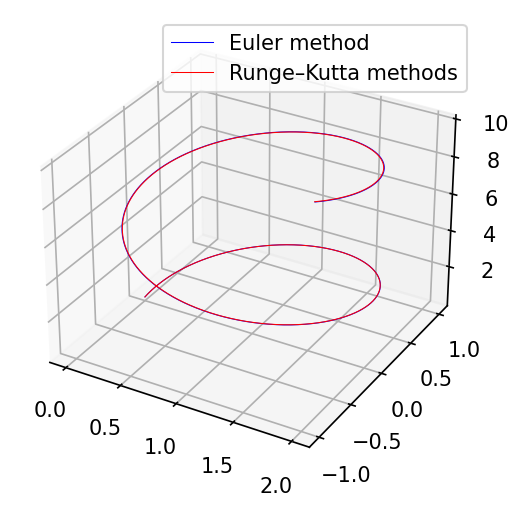

In [25]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, x_euler, 'b')
plot_3d_path(ax, x_rk4, 'r')
ax.legend(['Euler method', 'Runge–Kutta methods'])
plt.show()

Оба метода хорошо справились с простой системой, так что буду использовать только Эйлера.

## 2.2. Back pass

In [26]:
def psi(state, t):
    psi1, psi2, psi3 = state
    dpsi1dt = psi2
    dpsi2dt = - psi1
    dpsi3dt = 0.
    return jnp.array([dpsi1dt, dpsi2dt, dpsi3dt])

psi_euler = Euler_method(
    partial(psi),
    y0 = jnp.array([-1., 0., 0.]),
    t = jnp.linspace(0, 10., 10000)[::-1] # проход в обратном времени!
)

In [27]:
psi_euler

Array([[-1.0000000e+00, -9.9945068e-04,  0.0000000e+00],
       [-9.9999899e-01, -1.9998550e-03,  0.0000000e+00],
       [-9.9999696e-01, -3.0002585e-03,  0.0000000e+00],
       ...,
       [ 8.4437060e-01,  5.4505736e-01,  0.0000000e+00],
       [ 8.4382552e-01,  5.4590183e-01,  0.0000000e+00],
       [ 8.4327954e-01,  5.4674572e-01,  0.0000000e+00]], dtype=float32)

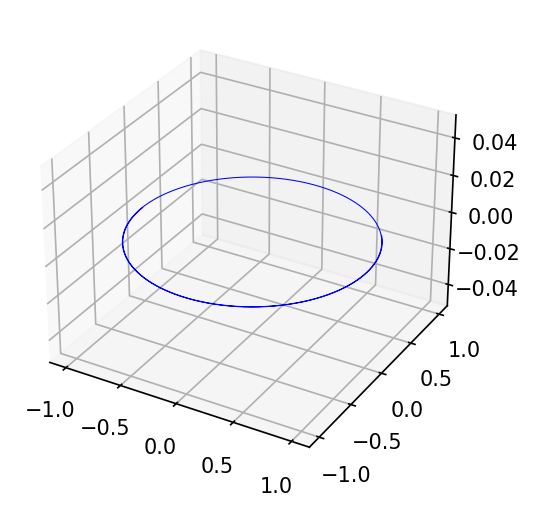

In [28]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')  # Создание трехмерных осей
plot_3d_path(ax, psi_euler, 'b')
plt.show()  # Отображение графика

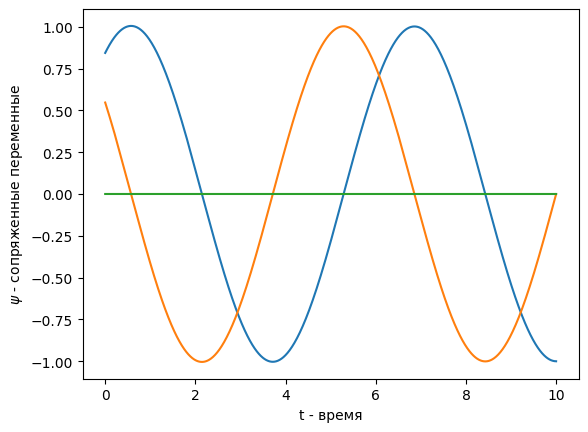

In [42]:
# Посмотрим что получилось (справа на лево т.к. шли в обратном времени)
import numpy as np
t = np.linspace(0, 10., 10000)[::-1]

import matplotlib.pyplot as plt
plt.plot(t[1:], psi_euler[:, 0])
plt.plot(t[1:], psi_euler[:, 1])
plt.plot(t[1:], psi_euler[:, 2])
plt.xlabel('t - время')
plt.ylabel('$\psi$ - сопряженные переменные')
plt.show()  # Отображение графика

Нужно выбрать управление, которое бы макимизировало функцию Понтрягина. 

От упраления зависит только $u\psi_2$. 

Соответсвенно, учитывая ограничение на управление, $u(t) = signum(\psi_2(t))$

### 1.3 Проверим, сошлось ли решение

Делаем снова прямой проход ОДУ + сопряженной системы.

In [44]:
def signum(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0
        

def f_and_psi(state, t, psi2T):
    x1, x2, psi1, psi2 = state
    u = signum(psi2T)
    dx1dt = x2
    dx2dt = - x1 + u
    dpsi1dt = psi2
    dpsi2dt = - psi1
    psi2T = psi2
    return jnp.array([dx1dt, dx2dt, dpsi1dt, dpsi2dt])

<!-- 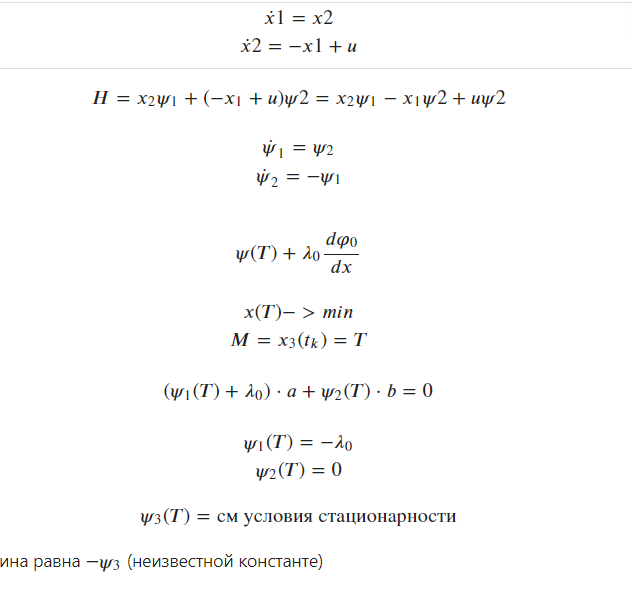 -->

In [45]:
psi_T1 = psi_euler[-1][0].item()
psi_T2 = psi_euler[-1][1].item()
psi_T1, psi_T2 

(0.8432795405387878, 0.5467457175254822)

In [46]:
solve = Euler_method(
    partial(f_and_psi, psi2T = psi_T2),
    y0 = jnp.array([0., 0., psi_T1 , psi_T2]),
    t = jnp.linspace(0, 10., 10000)
)

Если $\psi_1(T) = -1$, а $\psi_2(T) = 0$, то алгоритм сошелся. Иначе - новая итерация.

In [48]:
x1, x2, psi1, psi2 = solve[-1]

In [50]:
psi1.item(), psi2.item()

(-1.0100501775741577, 4.559706212603487e-07)

### Алгоритм сошелся т.к. система простая и управление $u$ не зависит от $x$